In [17]:
import ROOT
from ROOT import TMVA 
import os
from array import array

In [18]:
ROOT.TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize()

In [19]:
import torch
print(torch.__path__)


['/home/neel/jupyter/environment/lib/python3.8/site-packages/torch']


In [20]:
import torch
print (torch.__version__)


1.11.0+cu102


In [21]:
import torchvision
print (torchvision.__version__)

0.12.0+cu102


In [22]:
outputFile = ROOT.TFile.Open("CNN_ClassificationOutput.root", "RECREATE")

factory = ROOT.TMVA.Factory("TMVA_CNN_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

In [23]:
opt=[1,1,1,1,1]
useTMVACNN = opt[0] if (len(opt) > 0) else False
useKerasCNN = opt[0] if (len(opt) > 1) else False
useTMVADNN = opt[0] if (len(opt) > 2) else False
useTMVABDT = opt[0] if (len(opt) > 3) else False
usePyTorchCNN = opt[0] if (len(opt) > 4) else False
# useTMVACNN = False

writeOutputFile = True

num_threads = 0  # use default threads


In [24]:
# do enable MT running
if (num_threads >= 0):
  ROOT.EnableImplicitMT(num_threads)
  if (num_threads > 0):
     ROOT.gSystem.Setenv("OMP_NUM_THREADS", ROOT.TString.Format("%d",num_threads))

else:
  ROOT.gSystem.Setenv("OMP_NUM_THREADS", "1")

print("Running with nthreads  = " + str(ROOT.GetThreadPoolSize()) )

Running with nthreads  = 4


In [25]:
if __debug__:
    ROOT.gSystem.Setenv("KERAS_BACKEND", "tensorflow")
    # for using Keras
#     TMVA.PyMethodBase.PyInitialize()
else:
    useKerasCNN = False

In [26]:
loader = ROOT.TMVA.DataLoader("dataset")

In [27]:
imgSize = 16 * 16
inputFileName = "images_data_16x16.root"
inputFile = ROOT.TFile.Open(inputFileName)
if (inputFile == None):
    Error("TMVA_CNN_Classification", "Error opening input file %s - exit", inputFileName.Data())
signalTree     = inputFile.Get("sig_tree")
backgroundTree = inputFile.Get("bkg_tree")

signalTree.Print()


******************************************************************************
*Tree    :sig_tree  : signal_tree                                            *
*Entries :     5000 : Total =         5207924 bytes  File  Size =    4659345 *
*        :          : Tree compression factor =   1.12                       *
******************************************************************************
*Br    0 :vars      : vector<float>                                          *
*Entries :     5000 : Total  Size=    5207506 bytes  File Size  =    4657486 *
*Baskets :      167 : Basket Size=      32000 bytes  Compression=   1.12     *
*............................................................................*


In [28]:
nEventsSig = signalTree.GetEntries()
nEventsBkg = backgroundTree.GetEntries()
# global event weights per tree (see below for setting event-wise weights)
signalWeight = 1.0
backgroundWeight = 1.0

# You can add an arbitrary number of signal or background trees
loader.AddSignalTree(signalTree, signalWeight)
loader.AddBackgroundTree(backgroundTree, backgroundWeight)

## add event variables (image)
## use new method (from ROOT 6.20 to add a variable array for all image data)
 
loader.AddVariablesArray("vars",imgSize,'F')

# Set individual event weights (the variables must exist in the original TTree)
#    for signal    : factory.SetSignalWeightExpression    ("weight1*weight2")
#    for background: factory.SetBackgroundWeightExpression("weight1*weight2")
# loader.SetBackgroundWeightExpression( "weight" )

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree sig_tree of type Signal with 5000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree bkg_tree of type Background with 5000 events


In [29]:
# Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("") # for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("") # for example: TCut mycutb = "abs(var1)<0.5";

In [30]:
#  If no numbers of events are given, half of the events in the tree are used
#  for training, and the other half for testing:
#     loader.PrepareTrainingAndTestTree( mycut, "SplitMode=random:!V" );
#  It is possible also to specify the number of training and testing events,
#  note we disable the computation of the correlation matrix of the input variables

nTrainSig = 0.8 * nEventsSig
nTrainBkg = 0.8 * nEventsBkg

#  build the string options for DataLoader::PrepareTrainingAndTestTree
prepareOptions = "nTrain_Signal="+str(nTrainSig)+":nTrain_Background="+str(nTrainBkg)+":SplitMode=Random:SplitSeed=100:NormMode=NumEvents:!V:!CalcCorrelations"
  
loader.PrepareTrainingAndTestTree(mycuts, mycutb, prepareOptions)


In [31]:
if (useTMVABDT):
  factory.BookMethod(loader, ROOT.TMVA.Types.kBDT, "BDT","!V:NTrees=400:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:"+"UseBaggedBoost:BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20")



Factory                  : Booking method: BDT
                         : 
                         : Rebuilding Dataset dataset
                         : Building event vectors for type 2 Signal
                         : Dataset[dataset] :  create input formulas for tree sig_tree
                         : Using variable vars[0] from array expression vars of size 256
                         : Building event vectors for type 2 Background
                         : Dataset[dataset] :  create input formulas for tree bkg_tree
                         : Using variable vars[0] from array expression vars of size 256
DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : ---------------------------------------------------------------------------
                         : Signal     -- training events            : 4000
         

In [32]:
# Define the DNN layout
if (useTMVADNN):
  layoutString = "Layout=DENSE|100|RELU,BNORM,DENSE|100|RELU,BNORM,DENSE|100|RELU,BNORM,DENSE|100|RELU,DENSE|1|LINEAR"

  #  Training strategies
  #  one can catenate several training strings with different parameters (e.g. learning rates or regularizations
  #  parameters) The training string must be concatenates with the `|` delimiter
  trainingString1 = "LearningRate=1e-3,Momentum=0.9,Repetitions=1,"+ "ConvergenceSteps=5,BatchSize=100,TestRepetitions=1,"+"MaxEpochs=20,WeightDecay=1e-4,Regularization=None,"+"Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0."
                          

  trainingStrategyString = "TrainingStrategy="
  trainingStrategyString += trainingString1 # + "|" + trainingString2 + ....

  # Build now the full DNN Option string

  dnnOptions = "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:"+"WeightInitialization=XAVIER"
  dnnOptions+= ":"
  dnnOptions+= layoutString
  dnnOptions+= ":"
  dnnOptions+= trainingStrategyString

  dnnMethodName = "TMVA_DNN_CPU"

  dnnOptions += ":Architecture=CPU"


factory.BookMethod(loader, ROOT.TMVA.Types.kDL, dnnMethodName, dnnOptions)

Factory                  : Booking method: TMVA_DNN_CPU
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=XAVIER:Layout=DENSE|100|RELU,BNORM,DENSE|100|RELU,BNORM,DENSE|100|RELU,BNORM,DENSE|100|RELU,DENSE|1|LINEAR:TrainingStrategy=LearningRate=1e-3,Momentum=0.9,Repetitions=1,ConvergenceSteps=5,BatchSize=100,TestRepetitions=1,MaxEpochs=20,WeightDecay=1e-4,Regularization=None,Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.:Architecture=CPU"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=XAVIER:Layou

In [33]:
inputLayoutString ="InputLayout=1|16|16"

#  Batch Layout
layoutString = "Layout=CONV|10|3|3|1|1|1|1|RELU,BNORM,CONV|10|3|3|1|1|1|1|RELU,MAXPOOL|2|2|1|1,"+"RESHAPE|FLAT,DENSE|100|RELU,DENSE|1|LINEAR"

#  Training strategies.
trainingString1 = "LearningRate=1e-3,Momentum=0.9,Repetitions=1,"+"ConvergenceSteps=5,BatchSize=100,TestRepetitions=1,"+"MaxEpochs=20,WeightDecay=1e-4,Regularization=None,"+"Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.0"

trainingStrategyString = "TrainingStrategy="
trainingStrategyString += trainingString1 # + "|" + trainingString2 + "|" + trainingString3; for concatenating more training strings

# Build full CNN Options.


cnnOptions = "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:" +"WeightInitialization=XAVIER::Architecture=CPU"

cnnOptions +=  ":" + inputLayoutString
cnnOptions +=  ":" + layoutString
cnnOptions +=  ":" + trainingStrategyString
  ## New DL (CNN)
cnnMethodName = "TMVA_CNN_CPU"
# use GPU if available


cnnOptions += ":Architecture=CPU"
cnnMethodName = "TMVA_CNN_CPU"


factory.BookMethod(loader, ROOT.TMVA.Types.kDL, cnnMethodName, cnnOptions)


Factory                  : Booking method: TMVA_CNN_CPU
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=XAVIER::Architecture=CPU:InputLayout=1|16|16:Layout=CONV|10|3|3|1|1|1|1|RELU,BNORM,CONV|10|3|3|1|1|1|1|RELU,MAXPOOL|2|2|1|1,RESHAPE|FLAT,DENSE|100|RELU,DENSE|1|LINEAR:TrainingStrategy=LearningRate=1e-3,Momentum=0.9,Repetitions=1,ConvergenceSteps=5,BatchSize=100,TestRepetitions=1,MaxEpochs=20,WeightDecay=1e-4,Regularization=None,Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.0:Architecture=CPU"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CRO

In [34]:

pyTorchFileName = str(ROOT.gROOT.GetTutorialDir()) + "/tmva/PyTorch_Generate_CNN_Model.py"

ROOT.Info("TMVA_CNN_Classification", "Booking PyTorch CNN model")
methodOpt = "H:!V:VarTransform=None:FilenameModel=PyTorchModelCNN.pt:" + "FilenameTrainedModel=PyTorchTrainedModelCNN.pt:NumEpochs=20:BatchSize=100"
methodOpt += ":UserCode=" + pyTorchFileName
factory.BookMethod(loader, ROOT.TMVA.Types.kPyTorch, "PyTorch", methodOpt)

custom objects for loading model :  {'optimizer': <class 'torch.optim.adam.Adam'>, 'criterion': BCELoss(), 'train_func': <function fit at 0x7fe9297815e0>, 'predict_func': <function predict at 0x7fe8b9519310>}


Factory                  : Booking method: PyTorch
                         : 
                         : Using PyTorch - setting special configuration options 
                         : Using PyTorch version 1
                         :  Setup PyTorch Model 
                         :  Executing user initialization code from  /home/neel/Root/install/tutorials/tmva/PyTorch_Generate_CNN_Model.py
                         : Loaded pytorch train function: 
                         : Loaded pytorch optimizer: 
                         : Loaded pytorch loss function: 
                         : Loaded pytorch predict function: 
                         : Load model from file: PyTorchModelCNN.pt


Info in <TMVA_CNN_Classification>: Booking PyTorch CNN model


In [35]:
#  ## Train Methods

factory.TrainAllMethods()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Reshape)
  (1): RecursiveScriptModule(original_name=Conv2d)
  (2): RecursiveScriptModule(original_name=ReLU)
  (3): RecursiveScriptModule(original_name=BatchNorm2d)
  (4): RecursiveScriptModule(original_name=Conv2d)
  (5): RecursiveScriptModule(original_name=ReLU)
  (6): RecursiveScriptModule(original_name=MaxPool2d)
  (7): RecursiveScriptModule(original_name=Flatten)
  (8): RecursiveScriptModule(original_name=Linear)
  (9): RecursiveScriptModule(original_name=ReLU)
  (10): RecursiveScriptModule(original_name=Linear)
  (11): RecursiveScriptModule(original_name=Sigmoid)
)
[1, 4] train loss: 1.661
[1, 8] train loss: 0.747
[1, 12] train loss: 0.714
[1, 16] train loss: 0.703
[1, 20] train loss: 0.702
[1, 24] train loss: 0.693
[1, 28] train loss: 0.695
[1, 32] train loss: 0.693
[1, 36] train loss: 0.692
[1, 40] train loss: 0.693
[1, 44] train loss: 0.693
[1, 48] train loss: 0.692
[1, 52] train loss:

In [36]:
## Test and Evaluate Methods

factory.TestAllMethods()

custom objects for loading model :  {'optimizer': <class 'torch.optim.adam.Adam'>, 'criterion': BCELoss(), 'train_func': <function fit at 0x7fe8bbedfc10>, 'predict_func': <function predict at 0x7fe8b5474790>}
Factory                  : Test all methods
Factory                  : Test method: BDT for Classification performance
                         : 
BDT                      : [dataset] : Evaluation of BDT on testing sample (2000 events)
                         : Elapsed time for evaluation of 2000 events: 0.0428 sec       
Factory                  : Test method: TMVA_DNN_CPU for Classification performance
                         : 
                         : Evaluate deep neural network on CPU using batches with size = 1000
                         : 
TMVA_DNN_CPU             : [dataset] : Evaluation of TMVA_DNN_CPU on testing sample (2000 events)
                         : Elapsed time for evaluation of 2000 events: 0.0115 sec       
Factory                  : Test method: TMVA_

In [37]:
factory.EvaluateAllMethods()

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: BDT
                         : 
BDT                      : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
                         : Dataset[dataset] :  variable plots are not produces ! The number of variables is 256 , it is larger than 200
Factory                  : Evaluate classifier: TMVA_DNN_CPU
                         : 
TMVA_DNN_CPU             : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
                         : Evaluate deep neural network on CPU using batches with size = 1000
                         : 
                         : Dataset[dataset] :  variable plots are not produces ! The number of variables is 256 , it is larger than 200
Factory                  : Evaluate classifier: TMVA_CNN_CPU
                         : 
TMVA_CNN_CPU             :

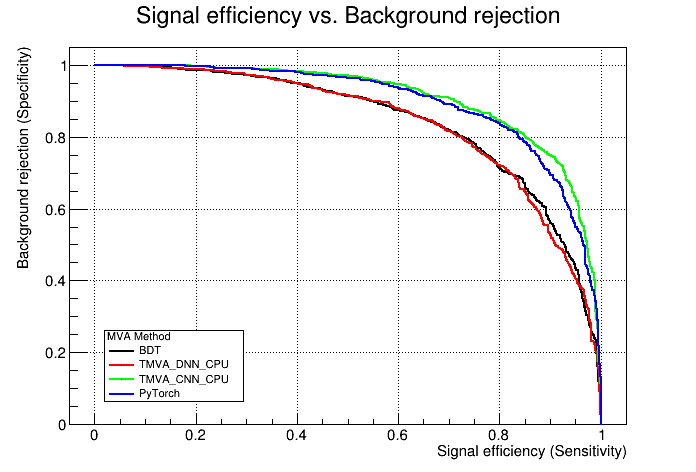

In [38]:
## Plot ROC Curve

c1 = factory.GetROCCurve(loader)
c1.Draw()


In [39]:
# close outputfile to save output file
outputFile.Close()